In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms 

In [3]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(DEVICE, torch.cuda.get_device_name(), '\ttorch_version : {}'.format(torch.__version__))

cuda NVIDIA GeForce GTX 1650 	torch_version : 1.12.0


In [4]:
BATCH_SIZE = 128
EPOCHS = 100 

In [16]:
train_dataset = datasets.CIFAR10(root='../../data/cifar10',
                                 download=True,
                                 train = True,
                                 transform= transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))
                                 ]))
test_dataset = datasets.CIFAR10(root='../../data/cifar10',
                                 download=True,
                                 train = False,
                                 transform= transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))
                                 ]))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           shuffle = True,
                                           batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           shuffle = False,
                                           batch_size = BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
for (X_train, y_train) in train_loader :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 3, 32, 32]) torch.Size([128])
torch.FloatTensor torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

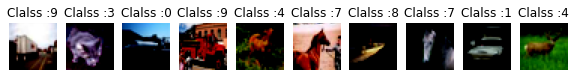

In [18]:
pltsize = 1 
plt.figure(figsize=(pltsize * 10, pltsize))
for i in range(10) :
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Clalss :' + str(y_train[i].item()))
plt.show()

# 오류는 noramlize 되어 있어서 그럼

In [28]:
class BasicBlock(nn.Module) :
    def __init__(self, in_planes, planes, stride=1) :
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3,
                               stride= stride,
                               padding = 1,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                                kernel_size=3,
                                stride=1,
                                padding=1,
                                bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes :
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1,
                          stride= stride,
                          bias=False),
                nn.BatchNorm2d(planes)
            )
    
    def forward(self, x) :
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module) :
    def __init__(self, num_classes=10) :
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride) :
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides :
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x) :
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [36]:
del model

In [37]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [38]:
def train(model, train_loader, optimizer, log_intervals = 100) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader) :
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0 :
            print('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset), 
                batch_idx * 100 / len(train_loader), loss.item()
            ))

In [39]:
def evaluate(model, test_loader) :
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad () :
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label) 
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy = correct * 100 / len(test_loader.dataset)
        return test_loss, test_accuracy

In [40]:
es = 0 
best_accuracy = 0

for Epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\nEPOCH : {}, Test_loss : {:.6f}, Test_accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_accuracy :
        best_accuracy = test_accuracy
        es = 0
        best_model = model
    else :
        es += 1

    if es >= 10 :
        print(best_accuracy)
        break

Train_Epoch : 1, [0 / 50000](0%)	Train_loss : 2.431217
Train_Epoch : 1, [12800 / 50000](26%)	Train_loss : 1.758827
Train_Epoch : 1, [25600 / 50000](51%)	Train_loss : 1.380175
Train_Epoch : 1, [38400 / 50000](77%)	Train_loss : 1.371258

EPOCH : 1, Test_loss : 0.000127, Test_accuracy : 54.50%

Train_Epoch : 2, [0 / 50000](0%)	Train_loss : 1.278360
Train_Epoch : 2, [12800 / 50000](26%)	Train_loss : 1.002121
Train_Epoch : 2, [25600 / 50000](51%)	Train_loss : 1.048265
Train_Epoch : 2, [38400 / 50000](77%)	Train_loss : 0.943573

EPOCH : 2, Test_loss : 0.000087, Test_accuracy : 65.75%

Train_Epoch : 3, [0 / 50000](0%)	Train_loss : 0.931088
Train_Epoch : 3, [12800 / 50000](26%)	Train_loss : 0.837504
Train_Epoch : 3, [25600 / 50000](51%)	Train_loss : 0.762137
Train_Epoch : 3, [38400 / 50000](77%)	Train_loss : 0.621286

EPOCH : 3, Test_loss : 0.000079, Test_accuracy : 68.45%

Train_Epoch : 4, [0 / 50000](0%)	Train_loss : 0.738423
Train_Epoch : 4, [12800 / 50000](26%)	Train_loss : 0.781937
Train_

# 파이토치내 제공모델 불러와 학습     

In [43]:
import torchvision.models as models
model2 = models.resnet34(pretrained = False)
# 해당하는 in_features 노드 수 받기
num_fts = model2.fc.in_features
# 아웃풋 값 조정
model2.fc = nn.Linear(num_fts, 10)
model2 = model.cuda()

c:\Users\Admin\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [44]:
es = 0 
best_accuracy = 0

for Epoch in range(1, EPOCHS + 1) :
    train(model2, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model2, test_loader)
    print('\nEPOCH : {}, Test_loss : {:.6f}, Test_accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_accuracy :
        best_accuracy = test_accuracy
        es = 0
        best_model = model2
    else :
        es += 1

    if es >= 10 :
        print(best_accuracy)
        break

Train_Epoch : 1, [0 / 50000](0%)	Train_loss : 0.093986
Train_Epoch : 1, [12800 / 50000](26%)	Train_loss : 0.054162
Train_Epoch : 1, [25600 / 50000](51%)	Train_loss : 0.107896
Train_Epoch : 1, [38400 / 50000](77%)	Train_loss : 0.119800

EPOCH : 1, Test_loss : 0.000128, Test_accuracy : 84.29%

Train_Epoch : 2, [0 / 50000](0%)	Train_loss : 0.043868
Train_Epoch : 2, [12800 / 50000](26%)	Train_loss : 0.072611
Train_Epoch : 2, [25600 / 50000](51%)	Train_loss : 0.078866
Train_Epoch : 2, [38400 / 50000](77%)	Train_loss : 0.071546

EPOCH : 2, Test_loss : 0.000135, Test_accuracy : 84.49%

Train_Epoch : 3, [0 / 50000](0%)	Train_loss : 0.104631
Train_Epoch : 3, [12800 / 50000](26%)	Train_loss : 0.072675
Train_Epoch : 3, [25600 / 50000](51%)	Train_loss : 0.059070
Train_Epoch : 3, [38400 / 50000](77%)	Train_loss : 0.094821

EPOCH : 3, Test_loss : 0.000076, Test_accuracy : 84.06%

Train_Epoch : 4, [0 / 50000](0%)	Train_loss : 0.080825
Train_Epoch : 4, [12800 / 50000](26%)	Train_loss : 0.146504
Train_